<a href="https://colab.research.google.com/github/Sophie-GJ/project-4-healthcare/blob/main/dementia_rf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Initial imports
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
# Mount Google Drive
drive.mount('/content/drive')
#import CSV as dataframe
df = pd.read_csv('drive/MyDrive/dementia_patients_health_data.csv')
df.head()

Mounted at /content/drive


,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,...,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,NaN,NaN,60,...,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,Galantamine,12.0,61,...,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,NaN,NaN,69,...,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,Donepezil,23.0,78,...,Never Smoked,Negative,Mild Activity,Yes,5,Yes,Balanced Diet,Poor,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,Memantine,20.0,77,...,Never Smoked,Positive,Mild Activity,No,0,Yes,Low-Carb Diet,Good,Diabetes,1


In [3]:
#drop columns with incomplete values
df = df.drop(columns=['Prescription', 'Dosage in mg', 'Medication_History'])
df.head()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Education_Level,Dominant_Hand,...,Family_History,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,60,Primary School,Left,...,No,Current Smoker,Negative,Sedentary,No,10,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,61,Secondary School,Right,...,No,Former Smoker,Positive,Moderate Activity,No,1,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,69,Primary School,Right,...,Yes,Former Smoker,Negative,Moderate Activity,No,8,Mediterranean Diet,Poor,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,78,Secondary School,Left,...,Yes,Never Smoked,Negative,Mild Activity,Yes,5,Balanced Diet,Poor,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,77,Secondary School,Right,...,Yes,Never Smoked,Positive,Mild Activity,No,0,Low-Carb Diet,Good,Diabetes,1


In [4]:
#Create a new RF model that doesn't consider age
# Define features (X) and target variable (y)
X = df.drop(columns=['Dementia', 'Age'])
y = df['Dementia']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [5]:
#Sort the features into buckets for the pipeline
num_features = ['AlcoholLevel', 'HeartRate', 'BloodOxygenLevel', 'BodyTemperature', 'Weight', 'MRI_Delay', 'Cognitive_Test_Scores']
cat_features = ['Diabetic', 'Dementia']
cat_transform_features = ['Family_History', 'Depression_Status', 'Education_Level','Dominant_Hand', 'Gender', 'Smoking_Status', 'APOE_ε4', 'Physical_Activity',  'Nutrition_Diet', 'Sleep_Quality', 'Chronic_Health_Conditions']

In [6]:
#create a numeric transformer
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

#create a categorical transformer
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(categories='auto')),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

In [7]:
#run the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_transform_features),
    ]
)

In [8]:
#create a RandomForest Model using the transformer pipeline
rf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(n_estimators=30, random_state=78))]
)

#fit the training data to the model
rf_model = rf.fit(X_train, y_train)
#display the model score
print("model score: %.3f" % rf_model.score(X_test, y_test))

model score: 1.000


In [9]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test)

In [10]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [11]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,129,0
Actual 1,0,121


Accuracy Score : 1.0
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       129
           1       1.00      1.00      1.00       121

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



In [12]:
# Access the RandomForestClassifier instance from the pipeline
rf_classifier = rf_model.named_steps['classifier']

# Get feature importances
importances = rf_classifier.feature_importances_

# Sort the features by their importance
sorted_importances = sorted(zip(importances, X.columns), reverse=True)

# Print the sorted feature importances
for importance, feature in sorted_importances:
    print(f"{feature}: {importance:.4f}")

MRI_Delay: 0.6858
Cognitive_Test_Scores: 0.0814
Gender: 0.0673
Family_History: 0.0569
Nutrition_Diet: 0.0243
Physical_Activity: 0.0162
HeartRate: 0.0116
BloodOxygenLevel: 0.0111
Diabetic: 0.0102
Weight: 0.0091
BodyTemperature: 0.0062
AlcoholLevel: 0.0044
Depression_Status: 0.0038
Dominant_Hand: 0.0029
Chronic_Health_Conditions: 0.0025
Smoking_Status: 0.0018
Sleep_Quality: 0.0008
Education_Level: 0.0002
APOE_ε4: 0.0000


<Axes: title={'center': 'Features Importances'}, ylabel='1'>

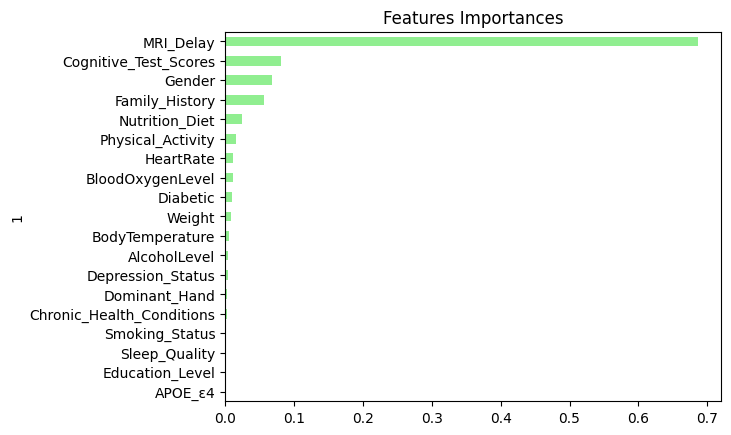

In [13]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_classifier.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)